In [14]:
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy
from scipy.spatial.distance import cdist
import sys
import os
from PIL import Image
sys.path.append("..")
import pylab as pl
import nplocate as nl
import src as ca
from src import *
from src import analysis
from src import properties
from src import figures as fig
from src import draw_spheres as ds
from src import g_r

# import scienceplots
# plt.style.use('science')
# plt.rcParams['xtick.top'] = False
# plt.rcParams['ytick.right'] = False
# font = {'family' : 'serif',
#         'weight' : 'normal',
#         'size'   : 18}

# plt.rc('font', **font)

def threshold_otsu(image=None, nbins=256, hist=None):
    """Return threshold value based on Otsu's method.
    Either image or hist must be provided. If hist is provided, the actual
    histogram of the image is ignored.
    Parameters
    ----------
    image : (N, M[, ..., P]) ndarray
        Grayscale input image.
    nbins : int, optional
        Number of bins used to calculate histogram. This value is ignored for
        integer arrays.
    hist : array, or 2-tuple of arrays, optional
        Histogram from which to determine the threshold, and optionally a
        corresponding array of bin center intensities.
        An alternative use of this function is to pass it only hist.
    Returns
    -------
    threshold : float
        Upper threshold value. All pixels with an intensity higher than
        this value are assumed to be foreground.
    """
    if image is not None and image.ndim > 2 and image.shape[-1] in (3, 4):
        msg = "threshold_otsu is expected to work correctly only for " \
              "grayscale images; image shape {0} looks like an RGB image"
        warn(msg.format(image.shape))

    # Check if the image has more than one intensity value; if not, return that
    # value
    if image is not None:
        first_pixel = image.ravel()[0]
        if np.all(image == first_pixel):
            return first_pixel

    counts, bin_edges = np.histogram(image.ravel(), bins=nbins)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    #counts, bin_centers = _validate_image_histogram(image, hist, nbins)

    # class probabilities for all possible thresholds
    weight1 = np.cumsum(counts)
    weight2 = np.cumsum(counts[::-1])[::-1]
    # class means for all possible thresholds
    mean1 = np.cumsum(counts * bin_centers) / weight1
    mean2 = (np.cumsum((counts * bin_centers)[::-1]) / weight2[::-1])[::-1]

    # Clip ends to align class 1 and class 2 variables:
    # The last value of ``weight1``/``mean1`` should pair with zero values in
    # ``weight2``/``mean2``, which do not exist.
    variance12 = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2

    idx = np.argmax(variance12)
    threshold = bin_centers[idx]

    return threshold

In [15]:
folder = '/Volumes/exp/code_pink/chapter5/300px_inuse/'
xyz_path = '/Volumes/exp/code_pink/chapter5/300px_inuse/xyz/30-350px/'
out_folder = '/Volumes/exp/code_pink/chapter5/300px_inuse/contacts/50-350px/Kris/'

In [26]:
## onestep version
## specify file_name and get contact imgs
px=0.1
s_iter = 4
## lets not play with dil_iter!
cps = ['fp3','fp4','pl1'] #polymer concentrations ,
colors = ['blue','green','orange']
concentration = ['0.35','0.16','0.20'] #in order with cps

for i,cp in enumerate(cps):
    print('Polymer concentration:',cp)
    contacts= np.loadtxt(out_folder+cp+'_coms.txt')
    removeLarge = contacts[:,-1]<800      #### !!!!!! Jun used 400
    contact_cen_new = contacts[removeLarge][:,:3]
    contact_cen = deepcopy(contact_cen_new)
    contact_size = contacts[removeLarge][:,-1]
    
    ###Rui powered 3/2 the contact size to area
    
    contact_area = contact_size
    print('how many contacts:',contact_cen_new.shape[0])    

    # compute distances between all contacts and particles
    dists=cdist(p_cen[:,:3], contact_cen)
#     dists.shape

    # which two particles have a common contact point
    p1_cen, p2_cen, p_tb_connected, connections, forces = analysis.link_particles(
                                dists,contact_cen,contact_area,p_cen)
    ## p_tb_connected is a tuple of index (contact, p1, p2)

    #if a contact is not collinear with two adjacent particles, put three of them collinear
    force_vector = analysis.find_force_vector(contact_cen,p1_cen, p2_cen,forces)
    np.savetxt(out_folder+cp+'pc_cc_vc1.txt',force_vector)

Polymer concentration: fp3
how many contacts: 2432
not devided by rtilde
2432
sum of all forces [10927.76282804 -1179.44771968 -1375.87883823]
finish
Polymer concentration: fp4
how many contacts: 6050
not devided by rtilde
6050
sum of all forces [107049.5971523   24665.57315019  55386.42240037]
finish
Polymer concentration: pl1
how many contacts: 5264
not devided by rtilde
5264
sum of all forces [-25918.74312812 -12158.23863797 -23385.61523768]
finish


In [24]:
## onestep version
## specify file_name and get contact imgs
px=0.1
s_iter = 4
## lets not play with dil_iter!
cps = ['fp3','fp4','pl1'] #polymer concentrations ,

colors = ['blue','green','orange']
concentration = ['0.35','0.16','0.20'] #in order with cps
##pl2 ap8的tracking不好因为drifting
# fig = plt.figure(figsize=(6,4)) #if all plot in one figure make it larger
## get contact imgs
for i,cp in enumerate(cps):
    print('Polymer concentration:',cp)
    tiff_img = Image.open(folder+cp+'_decon_contacts.tif')

    img = []
    for z in range(30,350):
        tiff_img.seek(z)
        data = tiff_img.convert('L')
        img.append(np.array(data))
    img = np.array(img)
    img = np.moveaxis(img, 0, -1) # 在这里，img的x和z被互换了，in the order of xyz

    # apply Otsu filter twice to the contacts image
    M = deepcopy(img)
    background =  threshold_otsu(M.ravel()) #otsu一次
    threshold_contact=threshold_otsu(M[M>background].ravel())
    print ('background threshold', background)
    print ('contacts threshold', threshold_contact)

    threshold_C2 = ds.threshold_top_bottom(M, M.max(), threshold_contact)

#     ## Particle centers and Generate a particle middle sphere mask

    xyz_file = xyz_path+cp+'_50-350px.xyz'
    pcen_all = np.loadtxt(
        xyz_file, delimiter='\t',
        skiprows=2, usecols=[1, 2, 3, 4]
    )

    p_cen = pcen_all
    p_rad = pcen_all[:,3]

    #### Calculate the distance of the first minimum in g(r)
    gr_resutls = []
    r,GR,IGR,IG=g_r.gr(xyz_file,1,1,1,screen=False)
    p_sigma, maxdistance = g_r.first_minimum(GR)
    gr_resutls.append((p_sigma,maxdistance))
    np.savetxt(out_folder+cp+'gr_.txt',max(gr_resutls))
    print('particle diameter in um:',max(gr_resutls)[0]*px,'neighbour distance in um:', max(gr_resutls)[1]*px)

    first_minimum = maxdistance
    neigbours_distance, n_p = ds.coordination(p_cen,maxdistance=first_minimum)[:2]

    sizeFactor = p_sigma/p_rad.mean()/2
#     print('size factor is',sizeFactor)
    
    print('how many particles',p_cen.shape[0])

    phi,pd,z_first,z_last = properties.volume_fraction(p_cen,M,factor=sizeFactor,z_range=True)
    print ('volume fraction, polydispersity:%s %s'%(phi,pd))
    
    # find middle points between particles
    middle_mask,particle_middle = ds.middle_point(p_cen,neigbours_distance,M)[:2]

    mask_thr =0# threshold_contact
    spheres, dimmask, struct_size = ds.draw_spheres(middle_mask, M, mask_thr,
                                                    s_iter,dil_iter=1)
    labelled_spheres, num_spheres, sphere_size = ds.label_mask(spheres)
    ## sphere_size is a list of contact sizes after 3 thresholds
    labelled_new_mask = labelled_spheres

    ## ostu_contacts is a tuple with 7 properties of x, xx,xxx,xxxx, H, volumeResiduals,minimum_intensity
    otsu_contacts= ds.force_pdf(M, labelled_new_mask,threshold_contact)

    thr_low = int(threshold_contact - 10)
    thr_high = int(threshold_contact + 10)
    delta_thr = 4
    low_threshold = range(thr_low,thr_high,delta_thr)
    histograms = [ds.force_pdf(M,labelled_new_mask,intensity) for intensity in low_threshold]

    coms, maxs, shifted_maxs,contact_size,residualContacts,residualLabels =ds.label_contactCentre(M,
                                                            labelled_new_mask,threshold_contact)[:-1]
    ds.contact_centre_save(np.array(coms),contact_size,
                           out_folder+cp+'_coms.txt')
    nl.save_xyz(out_folder+cp+'_contacts.xyz', [coms])
    
    # M2 = M > (threshold_contact)
    # M3 = M2*labelled_new_mask
    # M3[M3>0]=1
#     fig.multichecking(M,M3,50,150,250)
#     plt.savefig(out_folder+'contact_tracking'+cp+'.jpg')
    
    contacts= np.loadtxt(out_folder+cp+'_coms.txt')
    removeLarge = contacts[:,-1]<800      #### !!!!!! Jun used 400
    contact_cen_new = contacts[removeLarge][:,:3]
    contact_cen = deepcopy(contact_cen_new)
    contact_size = contacts[removeLarge][:,-1]
    
    ###Rui powered 3/2 the contact size to area
    
    contact_area = contact_size
    print('how many contacts:',contact_cen_new.shape[0])    

    # compute distances between all contacts and particles
    dists=cdist(p_cen[:,:3], contact_cen)
#     dists.shape

    # which two particles have a common contact point
    p1_cen, p2_cen, p_tb_connected, connections, forces = analysis.link_particles(
                                dists,contact_cen,contact_area,p_cen)
    ## p_tb_connected is a tuple of index (contact, p1, p2)

    #if a contact is not collinear with two adjacent particles, put three of them collinear
    force_vector = analysis.find_force_vector(contact_cen,p1_cen, p2_cen,forces)
    np.savetxt(out_folder+cp+'pc_cc_vc1.txt',force_vector)

Polymer concentration: fp3
background threshold 9.462890625
contacts threshold 20.048828125
particle diameter in um: 2.7 neighbour distance in um: 3.5
how many particles 1695
number of particles at the edges 49
Num of inside particles 1646 factor 1.133831648299666 1695
volume fraction, polydispersity:0.23177450322356052 0.10823252118417688
20.048828125 2432
0 391.5
10 3424
2 595.0
14 3104
1 475.5
18 2726
0 434.95
22 2180
0 365.1
26 1540
0 280.95


TypeError: arrays to stack must be passed as a "sequence" type such as list or tuple.

In [19]:
contact_size.shape

(2433,)

In [23]:
len(coms)

2433

In [ ]:
# plot Nz, Vc, I along z
#     fig=plt.figure()
#     bin_num=20
#     bins = np.linspace(0, contacts[:,0].max(), bin_num)
#     bincenter = (bins[1:]+bins[:-1])/2
#     digitized = np.digitize(contacts[:,0], bins)
#     bin_means = [contacts[digitized == i][:,3].mean() for i in range(1, len(bins))]
#     plt.hist(contact_cen[:,0], bins=bin_num,color=colors[i],alpha=0.3,label = '$N_{Z}$')
#     plt.plot(bincenter,bin_means,lw=2, linestyle='dashed',color=colors[i],label ='$V_{Z}$')
#     plt.plot(M.mean(axis=(0,1))*10, lw=2,color=colors[i], label ='$I_{Z}$')
#     plt.xlim(0,bincenter.max())
#     plt.ylim(0,420)
#     plt.legend()
#     plt.xlabel('$Z$ (px)')
#     plt.ylabel('$N_{Z}$')
#     plt.legend(loc =1)
#     plt.savefig(folder+cp+'alongz.pdf')

In [ ]:
    # number of contacts distribution along z direction
#     bin_num=20
#     plt.hist(contact_cen[:,0], bins=bin_num,color=colors[i],alpha=0.3)
#     plt.xlabel('Z - direction (px)')
#     plt.ylabel('Contacts along Z')
#     plt.plot(M.mean(axis=(0,1))*10, lw=2,color=colors[i], label=concentration[i])
#     plt.xlim(0,M.shape[2])
#     plt.legend(loc=1)
    
    # number of contacts distribution along z direction
#     for j in range(0,contacts.shape[0],25):
#         plt.scatter(contacts[j,0],contacts[j,3], color=colors[i],alpha=0.3)
#     plt.xlabel('$Z$')
#     plt.ylabel('$v_{c}$')
#     plt.legend(loc=1)

In [ ]:
    # calculate number of contacts per particle
    # sum of force per particle with magnitude or not
#     ncontacts,local_sum,local_sum_moduli,order,local_f_list,local_f_sum = analysis.n_contacts_pparticle(
#                                                     p_tb_connected,force_vector,p_cen)
    
# plot local sum histogram
#     plt.hist(local_sum, bins = 10, alpha=0.3,color=colors[i],density = True,label = concentration[i])
#     plt.xlabel('Local pressure $tr(\sigma)$')
#     plt.ylabel('P($tr(\sigma)$)')
#     plt.xlim(0,200)
#     plt.legend(loc=1)
#    local_sum is actually the norm of a net force
#     coordinations = analysis.coordination(p_cen,maxdistance)
#     np.savetxt(out_folder+cp+'_nContacts.txt', ncontacts)
#     np.savetxt(out_folder+cp+'_Neighbors.txt', coordinations)

#     fig.write_xyz_file_p(out_folder + cp + 'particle_localsum',
#                                 p_cen[:,:3],Property =local_sum)
    
#     # get positions and values with large force magnitude
#     largeForce = local_sum>=local_sum.mean()
#     print('large force',local_sum.mean())
#     fig.write_xyz_file_p(out_folder + cp + 'particle_forceMagnitude_large',
#                                 p_cen[largeForce][:,:3],Property =local_sum[largeForce])
    
#     #### get stress tensor
#     ## f direction is contacts to particles, r direction is opposite
#     stress_tensor, parToCon_list = ca.force_chains3d.compute_stress(p_cen,contact_cen,local_f_list,dists)
#     major_stress, minor_stress, eigvals,stress_trace,anisotropy = ca.force_chains3d.principal_stress(stress_tensor)
    
#     np.savetxt(out_folder + cp + 'minor_stress.txt',np.array(minor_stress).real)
#     np.savetxt(out_folder + cp + 'major_stress.txt',np.array(major_stress).real)
#     np.savetxt(out_folder + cp + 'stress_trace.txt',np.array(stress_trace).real)
#     np.savetxt(out_folder + cp + 'anisotropy.txt',anisotropy)
# #     np.savetxt(out_folder + cp + 'particle_stress_index.txt',p_inbox)
    
    
#     #### start looking for force chains, first find particles not alone
#     neighbours_distance, coordinations = ds.coordination(p_cen[:,:3],maxdistance=maxdistance)[:-1]
#     neighbours_distance=np.array(neighbours_distance) ##particle, its neighbour, distances
#     non_alone = np.where(coordinations>=1)[0]
#     np.savetxt(out_folder +cp + 'non_alone.txt',non_alone)
    
#     ##then looking for particles with high stress (actually finding non along particles neighbours)
#     highStress_neighbours=[] 
#     for i in non_alone:  
#         idx = np.where(neighbours_distance[:,0]==i)[0]
#         newneigh = []
#         for j in idx:
#             neighbours = neighbours_distance[j][1]
#             newneigh.append(neighbours)
#         highStress_neighbours.append((i,newneigh)) ##并没有threshold highstress particles
#     ##find chains
#     chain_computed = ca.force_chains3d.find_chains(p_cen,
#                             coordinations,highStress_neighbours,minor_stress,eigvals,threshold=45)
#     chain_color = chain_computed[0]
#     uu,vv,ww = chain_computed[1],chain_computed[2],chain_computed[3]
#     XYZ,pairs,Neigh = chain_computed[-3],chain_computed[-2],chain_computed[-1]
#     ## pairs
#     chainlength,labelled_chain,coloredP,length = ca.force_chains3d.color_chains(
#                                             chain_color,p_cen,non_alone)
#     ##coloredP is non alone particle zyx and radii
#     NP_inChain = length[length>2].shape[0] ##how many chains are longer than 2
    
#     to_delete = []
#     for i in range(len(pairs)):
#         for j in range(i+1,len(pairs)):
#             if pairs[i] == pairs[j][::-1]: ## ::-1 inverse array
#                 to_delete.append(j)

#     new_pairs = np.delete(pairs,to_delete,axis=0)
#     long_pairs =[]
#     for i in range(len(new_pairs)):
#         Lchain = length[new_pairs[i][0]]
#         if Lchain >3:
#             long_pairs.append((new_pairs[i][0],new_pairs[i][1],Lchain)) ##idx_p1, idx_p2, chainlength

#     pair_index = []
#     for i in range(len(long_pairs)):
#         p1 = new_pairs[i][0]
#         p2 = new_pairs[i][1]
#         old_p1 = non_alone[p1]
#         old_p2 = non_alone[p2]
#         c_idx =np.where(p_tb_connected[:,1]==old_p1)[0]
#         if p_tb_connected[c_idx].shape[0]>0:
#             connect_p = p_tb_connected[c_idx]
#             matched = [p==old_p2 for p in connect_p[:,-1]]
#             if any(matched):
#                 size = connect_p[matched][0][0]
#                 pair_index.append((p1,p2,size))
#     pair_index = np.array(pair_index)

#     pair_index_oldp = []
#     for i in range(len(long_pairs)):
#         p1 = long_pairs[i][0]
#         p2 = long_pairs[i][1]
#         old_p1 = non_alone[p1]
#         old_p2 = non_alone[p2]

#         pair_index_oldp.append((old_p1,old_p2))
#     pair_index_oldp = np.array(pair_index_oldp)
    
#     chains = np.c_[p_cen[non_alone],labelled_chain,length] ## particle non alone: z,y,x,radii,in_chain_index,chain_length
#     nl.save_xyz(out_folder+cp+'_chains.xyz', [chains])
#     np.savetxt(out_folder+cp+'chains.txt',chains) 
#     np.savetxt(out_folder+cp+'chainlength_t%02d.txt',length)

In [4]:
def multichecking(img,contact_img,slice1,slice2,slice3):
    plt.subplot(131).imshow(img[:, :, slice1])
    plt.subplot(131).imshow(contact_img[:,:,slice1],alpha=0.5)
    plt.title('bottom')
    plt.subplot(132).imshow(img[:, :, slice2])
    plt.subplot(132).imshow(contact_img[:,:,slice2],alpha=0.5)
    plt.title('middle')
    plt.subplot(133).imshow(img[:, :, slice3])
    plt.subplot(133).imshow(contact_img[:,:,slice3],alpha=0.5)
    plt.title('top')
    plt.show()

(array([371., 197., 138., 139., 128., 117., 103.,  96., 103., 103.,  88.,
         69., 100.,  97.,  77.,  76.,  79.,  78.,  64.,  89.,  90.,  93.,
         79.,  70.,  62.,  80.,  70.,  71.,  76.,  72.,  69.,  73.,  78.,
         78.,  73.,  60.,  49.,  53.,  67.,  78.,  59.,  55.,  72.,  55.,
         64.,  61.,  71.,  54.,  59.,  53.,  64.,  48.,  57.,  51.,  51.,
         39.,  51.,  41.,  47.,  53.,  49.,  48.,  35.,  39.,  47.,  29.,
         31.,  26.,  21.,  25.,  21.,  12.,   2.,   1.,   2.,   2.,   1.,
          0.,   1.,   0.,   0.,   2.,   1.,   2.,   1.,   1.,   1.,   0.,
          0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   1.,   0.,   1.,
          2.]),
 array([  1.  ,   8.98,  16.96,  24.94,  32.92,  40.9 ,  48.88,  56.86,
         64.84,  72.82,  80.8 ,  88.78,  96.76, 104.74, 112.72, 120.7 ,
        128.68, 136.66, 144.64, 152.62, 160.6 , 168.58, 176.56, 184.54,
        192.52, 200.5 , 208.48, 216.46, 224.44, 232.42, 240.4 , 248.38,
        256.36, 264.34, 272.32

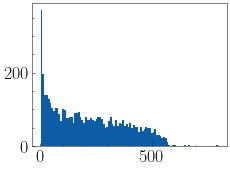

In [6]:
plt.hist(contact_size,bins = 100)

In [15]:
before = np.sqrt((-1.972077244430885656e+01)**2+(1.423252650513195405e+01)**2+(-4.763756515139488279e+00)**2)
after = np.sqrt((-3.663383534216815285e+00)**2+(2.643872261923059686e+00)**2+(-8.849281754993493232e-01)**2)

In [6]:
contact_area = contact_size**(3/2)

In [7]:
contact_area.shape

(2432,)

In [7]:
# see contacts, 1 concentration
px=0.1
s_iter = 4 ## lets not play with dil_iter!
# filen = ['fp3','fp4','pl1']
cps = ['fp4'] #polymer concentrations ,'0.20','0.35' 'fp3','fp4','fp3','pl1','fp4','pl1'

## get contact imgs
for cp in (cps):
    print('Polymer concentration:',cp)
    tiff_img = Image.open(folder+cp+'_decon_contacts.tif')

    img = []
    for z in range(30,350):
        tiff_img.seek(z)
        data = tiff_img.convert('L')
        img.append(np.array(data))
    img = np.array(img)
    img = np.moveaxis(img, 0, -1) # 在这里，img的x和z被互换了，in the order of xyz

    # apply Otsu filter twice to the contacts image
    M = deepcopy(img)
    background =  threshold_otsu(M.ravel()) #otsu一次
    threshold_contact=threshold_otsu(M[M>background].ravel())
#     print ('background threshold', background)
#     print ('contacts threshold', threshold_contact)

    threshold_C2 = ds.threshold_top_bottom(M, M.max(), threshold_contact)

#     ## Particle centers and Generate a particle middle sphere mask

    xyz_file = xyz_path+cp+'_50-350px.xyz'
    pcen_all = np.loadtxt(
        xyz_file, delimiter='\t',
        skiprows=2, usecols=[1, 2, 3, 4]
    )

    p_cen = pcen_all
    p_rad = pcen_all[:,3]
    print('how many particles',p_cen.shape[0])
    #### Calculate the distance of the first minimum in g(r)
    gr_resutls = []
    r,GR,IGR,IG=g_r.gr(xyz_file,1,1,1,screen=False)
    p_sigma, maxdistance = g_r.first_minimum(GR)
    gr_resutls.append((p_sigma,maxdistance))
#     np.savetxt(out_folder+cp+'gr_.txt',max(gr_resutls))
#     print('particle diameter in um:',max(gr_resutls)[0]*px,'neighbour distance in um:', max(gr_resutls)[1]*px)

    first_minimum = maxdistance
    neigbours_distance, n_p = ds.coordination(p_cen,maxdistance=first_minimum)[:2]

#     print('size factor is',sizeFactor)
    
    
    # find middle points between particles
    middle_mask,particle_middle = ds.middle_point(p_cen,neigbours_distance,M)[:2]

    mask_thr =0# threshold_contact
    spheres, dimmask, struct_size = ds.draw_spheres(middle_mask, M, mask_thr,
                                                    s_iter,dil_iter=1)
    labelled_spheres, num_spheres, sphere_size = ds.label_mask(spheres)
    ## sphere_size is a list of contact sizes after 3 thresholds
    labelled_new_mask = labelled_spheres

    ## ostu_contacts is a tuple with 7 properties of x, xx,xxx,xxxx, H, volumeResiduals,minimum_intensity
    otsu_contacts= ds.force_pdf(M, labelled_new_mask,threshold_contact)

    thr_low = int(threshold_contact - 10)
    thr_high = int(threshold_contact + 10)
    delta_thr = 4
    low_threshold = range(thr_low,thr_high,delta_thr)
    histograms = [ds.force_pdf(M,labelled_new_mask,intensity) for intensity in low_threshold]

    coms, maxs, shifted_maxs,contact_size,residualContacts,residualLabels =ds.label_contactCentre(M,
                                                            labelled_new_mask,threshold_contact)[:-1]


Polymer concentration: fp4
how many particles 2041
19.0234375 5857
0 422.3
9 6880
2 567.25
13 6671
1 506.69999999999993
17 6216
0 394.25
21 5351
0 439.35
25 4257
0 366.2


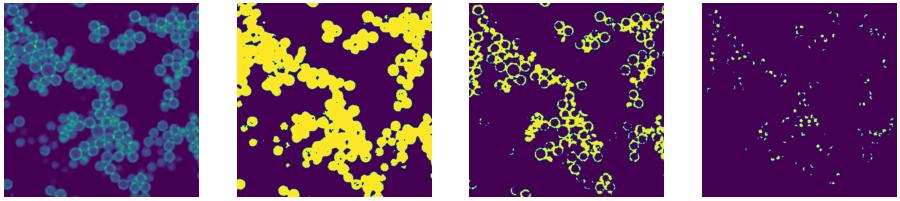

In [20]:
fig = plt.figure(figsize=(16,8))
M1 = M > background
M2 = M > (threshold_contact*1.1)
M3 = M2*labelled_new_mask
M3[M3>0]=1

plt.subplot(141).imshow(M[:,:,50])
plt.axis('off')
plt.subplot(142).imshow(M1[:, :, 50])
plt.axis('off')
plt.subplot(143).imshow(M2[:, :, 50])
plt.axis('off')
plt.subplot(144).imshow(M3[:,:,50])
plt.axis('off')
plt.show()

#     plt.savefig(out_folder+'contact_tracking'+cp+'.png')

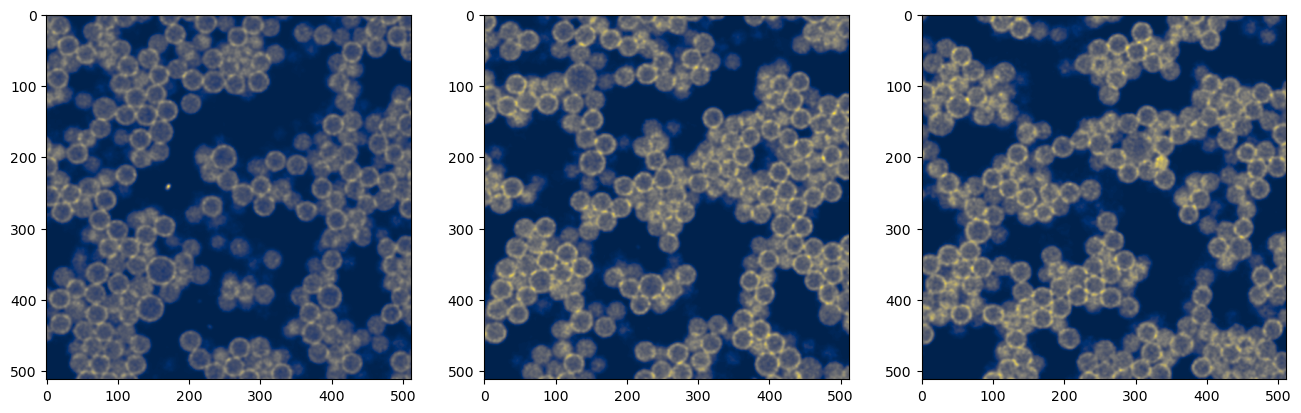

In [123]:
# see original images
z = 100
fig, axs = pl.subplots(1,3,figsize = (16,8))
axs[0].imshow(M[:,:,30],cmap = 'cividis')
axs[1].imshow(M[:,:,60],cmap = 'cividis')
axs[2].imshow(M[:,:,90],cmap = 'cividis')

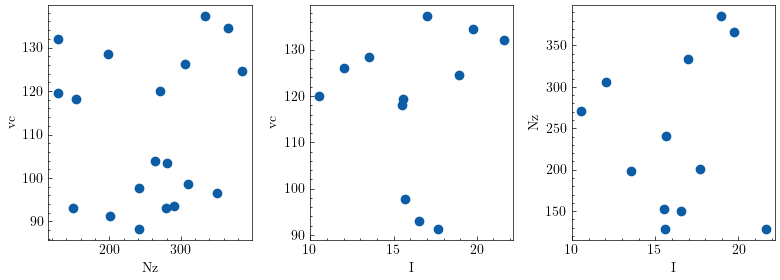

In [260]:
fig=plt.figure()
num_figure = 3

fig.add_subplot(1,num_figure,1)
plt.scatter(x[:-1],bin_means)
plt.xlabel('Nz')
plt.ylabel('vc')

fig.add_subplot(1,num_figure,2)
plt.scatter(Intensity,bin_means)
plt.xlabel('I')
plt.ylabel('vc')

fig.add_subplot(1,num_figure,3)
plt.scatter(Intensity,x[:-1])
plt.xlabel('I')
plt.ylabel('Nz')

fig.set_size_inches(8,3)
plt.tight_layout()

In [264]:
from scipy.optimize import curve_fit
def linear(x,a,b):
    return a*x+b

def linear_fit(func,x,y):
    parameters, cov = curve_fit(linear,x,y)
    return(parameters)

In [270]:
A,B = linear_fit(linear,Intensity[:12],x[:12])
X= np.linspace(0, 23, 100)
fit_y = linear(X, A, B)  

Text(0, 0.5, 'Nz')

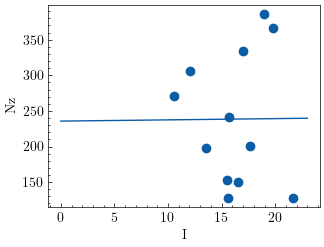

In [271]:
plt.scatter(Intensity,x[:-1])
plt.plot(X,fit_y)
plt.xlabel('I')
plt.ylabel('Nz')

In [252]:
I = M.mean(axis=(0,1))
Intensity = []
for i in range(len(rangez)-1):
    Intensity.append(np.mean(I[int(rangez[i]):int(rangez[i+1])]))


Text(0, 0.5, 'Along $Z$')

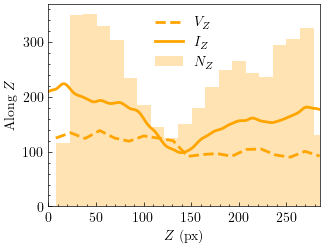

In [224]:
# contacts
fig=plt.figure()
bin_num=20
bins = np.linspace(0, contacts[:,0].max(), bin_num)
bincenter = (bins[1:]+bins[:-1])/2
digitized = np.digitize(contacts[:,0], bins)
bin_means = [contacts[digitized == i][:,3].mean() for i in range(1, len(bins))]
plt.hist(contact_cen[:,0], bins=bin_num,color=colors[i],alpha=0.3,label = '$N_{Z}$')

plt.plot(bincenter,bin_means,lw=2, linestyle='dashed',color=colors[i],label ='$V_{Z}$')
plt.plot(M.mean(axis=(0,1))*10, lw=2,color=colors[i], label ='$I_{Z}$')
plt.xlim(0,bincenter.max())
plt.legend()
plt.xlabel('$Z$ (px)')
plt.ylabel('Along $Z$')

In [201]:
digitized

array([11,  9,  5, ...,  7, 25,  8])

In [176]:
obj = ma.masked_inside(contacts[:,0],binedges[0],binedges[1])

In [170]:
binedges = np.arange(0,contacts.shape[0],10)

In [173]:
contacts[contacts[:,0]<binedges[1]]

array([[  8.,  89., 385., 187.]])

Text(0, 0.5, '$Z$')

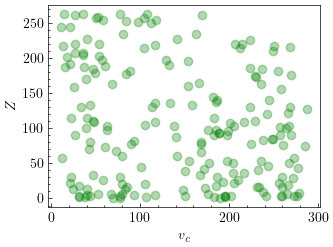

In [168]:
# number of contacts distribution along z direction
binedges = np.arange(0,contacts.shape[0],10)
contacts[binedges[0]<contacts[:,0]<binedges[1]]
for j in range(0,contacts.shape[0],25):
    plt.scatter(contacts[j,0],contacts[j,3], color='g',alpha=0.3,label='Contacts')
plt.xlabel('$Z$')
plt.ylabel('$v_{c}$')
plt.legend(loc=1)

In [143]:
#color type force magnitude in local sum
smallForce = local_sum<50
mediumForce = np.logical_and(local_sum>=50,local_sum<100)
largeForce = local_sum>=100
fig.write_xyz_file_p(out_folder + cp + 'localsum_small',
                            p_cen[smallForce][:,:3],Property =local_sum)
fig.write_xyz_file_p(out_folder + cp + 'localsum_medium',
                            p_cen[mediumForce][:,:3],Property =local_sum)
fig.write_xyz_file_p(out_folder + cp + 'localsum_large',
                            p_cen[largeForce][:,:3],Property =local_sum)

Polymer concentration: fp4
sphere size is 569
19.0234375 6238
0 438.25
9 7318
2 567.25
13 7107
1 519.0500000000001
17 6625
0 439.9
21 5694
0 439.35
25 4539
0 384.9
1264 6255 6255


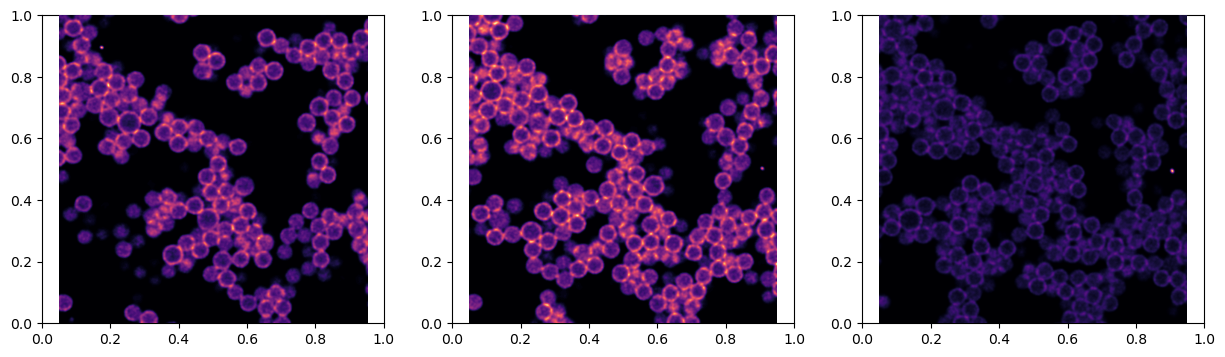

In [124]:
# checking contacts
px=0.1
s_iter = 4 ## lets not play with dil_iter!
# filen = ['fp3','fp4','pl1']
cps = ['fp4'] #polymer concentrations ,'0.20','0.35' 'fp3','fp4','fp3','pl1','fp4','pl1'

## get contact imgs
for cp in (cps):
    print('Polymer concentration:',cp)
    tiff_img = Image.open(folder+cp+'_decon_contacts.tif')

    img = []
    for z in range(30,350):
        tiff_img.seek(z)
        data = tiff_img.convert('L')
        img.append(np.array(data))
    img = np.array(img)
    img = np.moveaxis(img, 0, -1) # 在这里，img的x和z被互换了，in the order of xyz

    # apply Otsu filter twice to the contacts image
    M = deepcopy(img)
    background =  threshold_otsu(M.ravel()) #otsu一次
    threshold_contact=threshold_otsu(M[M>background].ravel())
#     print ('background threshold', background)
#     print ('contacts threshold', threshold_contact)

    threshold_C2 = ds.threshold_top_bottom(M, M.max(), threshold_contact)

#     ## Particle centers and Generate a particle middle sphere mask

    xyz_file = xyz_path+cp+'_50-350px.xyz'
    pcen_all = np.loadtxt(
        xyz_file, delimiter='\t',
        skiprows=2, usecols=[1, 2, 3, 4]
    )

    p_cen = pcen_all
    p_rad = pcen_all[:,3]
    print('how many particles',p_cen.shape[0])
    #### Calculate the distance of the first minimum in g(r)
    gr_resutls = []
    r,GR,IGR,IG=g_r.gr(xyz_file,1,1,1,screen=False)
    p_sigma, maxdistance = g_r.first_minimum(GR)
    gr_resutls.append((p_sigma,maxdistance))
#     np.savetxt(out_folder+cp+'gr_.txt',max(gr_resutls))
#     print('particle diameter in um:',max(gr_resutls)[0]*px,'neighbour distance in um:', max(gr_resutls)[1]*px)

    first_minimum = maxdistance
    neigbours_distance, n_p = ds.coordination(p_cen,maxdistance=first_minimum)[:2]

    sizeFactor = p_sigma/p_rad.mean()/2
    phi,pd,z_first,z_last = properties.volume_fraction(p_cen,xyz,factor=sizeFactor,z_range=True)
    print ('volume fraction, polydispersity,z first and last:%s %s'%(phi,pd))
#     print('size factor is',sizeFactor)
    
    
    # find middle points between particles
    middle_mask,particle_middle = ds.middle_point(p_cen,neigbours_distance,M)[:2]

    mask_thr =0# threshold_contact
    spheres, dimmask, struct_size = ds.draw_spheres(middle_mask, M, mask_thr,
                                                    s_iter,dil_iter=1)
    labelled_spheres, num_spheres, sphere_size = ds.label_mask(spheres)
    ## sphere_size is a list of contact sizes after 3 thresholds
    labelled_new_mask = labelled_spheres

    ## ostu_contacts is a tuple with 7 properties of x, xx,xxx,xxxx, H, volumeResiduals,minimum_intensity
    otsu_contacts= ds.force_pdf(M, labelled_new_mask,threshold_contact)

    thr_low = int(threshold_contact - 10)
    thr_high = int(threshold_contact + 10)
    delta_thr = 4
    low_threshold = range(thr_low,thr_high,delta_thr)
    histograms = [ds.force_pdf(M,labelled_new_mask,intensity) for intensity in low_threshold]

    coms, maxs, shifted_maxs,contact_size,residualContacts,residualLabels =ds.label_contactCentre(M,
                                                            labelled_new_mask,threshold_contact)[:-1]
#     ds.contact_centre_save(np.array(coms),contact_size,
#                            out_folder+cp+'_coms.txt')
#     nl.save_xyz(out_folder+cp+'_contacts.xyz', [coms])
    
    M2 = M > (threshold_contact)
    M3 = M2*labelled_new_mask
    M3[M3>0]=1
    multichecking(M,M3,50,60,70)
#     plt.savefig(out_folder+'contact_tracking'+cp+'.png')

In [141]:
mediumForce

array([ True, False, False, ...,  True,  True, False])

In [ ]:
# large_force is an xyz file based on p_cen, in z y x force
# long_chain is based on p_cen[non_alone]

pl1
102.16633527725038


(array([5.22266321e-03, 4.62235710e-03, 5.62786984e-03, 4.90750250e-03,
        4.09708924e-03, 2.62633926e-03, 9.90505092e-04, 6.60336728e-04,
        1.35068876e-04, 7.50382645e-05]),
 array([  0.        ,  34.52470005,  69.0494001 , 103.57410015,
        138.0988002 , 172.62350024, 207.14820029, 241.67290034,
        276.19760039, 310.72230044, 345.24700049]),
 <BarContainer object of 10 artists>)

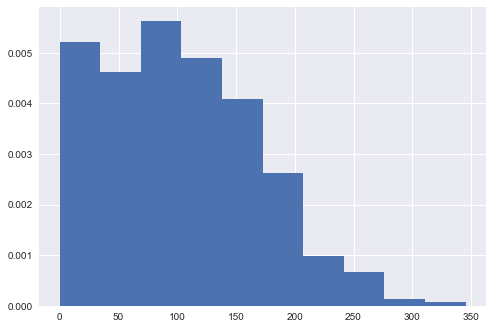

In [166]:
print(cp)
print(local_sum.mean())
plt.hist(local_sum,density=True)

In [196]:
# get positions and values with large force magnitude
largeForce = local_sum>=local_sum.mean()
print('large force',local_sum.mean())
# fig.write_xyz_file_p(out_folder +cp + 'large_force',
#                             p_cen[largeForce][:,:3],Property =local_sum[largeForce])

large force 98.06361161319417


In [177]:
# get positions of particles in long chains
long_chains=chains[chains[:,-1]>3]

In [201]:
short_chains=chains[chains[:,-1]==2]

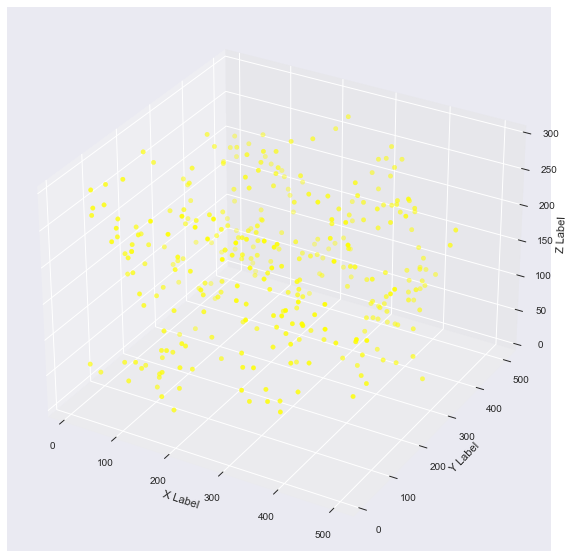

In [202]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

xf = p_cen[largeForce][:,2]
yf = p_cen[largeForce][:,1]
zf = p_cen[largeForce][:,0]

xl = long_chains[:,2]
yl = long_chains[:,1]
zl = long_chains[:,0]


xs = short_chains[:,2]
ys = short_chains[:,1]
zs = short_chains[:,0]

# ax.scatter(xf, yf, zf, marker='o',color = 'blue')

# ax.scatter(xl, yl, zl, marker='o',color = 'salmon')

ax.scatter(xs, ys, zs, marker='o',color = 'yellow')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [170]:
np.where(local_sum>150)[0].shape

(460,)

(array([0.92285072, 0.34596091, 0.        , 0.17384536, 0.        ,
        0.12108632, 0.06054316, 0.        , 0.0363259 , 0.00605432]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <BarContainer object of 10 artists>)

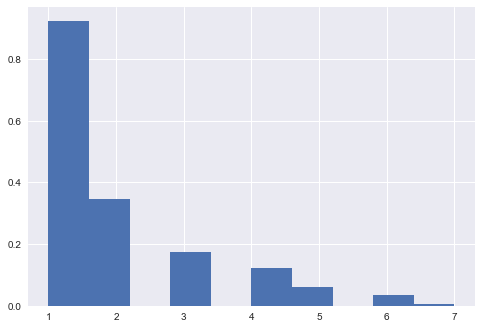

In [165]:
plt.hist(length,density = True)

In [160]:
largeForce = local_sum>=local_sum.mean()
print('large force',local_sum.mean())
fig.write_xyz_file_p(out_folder +cp + 'particle_forceMagnitude_large',
                            p_cen[largeForce][:,:3],Property =local_sum[largeForce])

(1927,)

In [154]:
p_tb_connected.shape 

(5119, 3)

In [159]:
force_vector.shape[0]/2

5119.0

In [156]:
p_cen.shape

(1930, 4)

In [132]:
len(long_pairs) ##idx_p1, idx_p2, chainlength

203

In [150]:
local_sum > local_sum.mean()

array([ True,  True, False, ...,  True,  True, False])

In [147]:
largeForce

array([ True,  True, False, ...,  True,  True, False])

In [ ]:
largeForce = local_sum>=local_sum.mean()

In [152]:
long_pairs

[(2, 117, 4.0),
 (117, 146, 4.0),
 (146, 506, 4.0),
 (29, 156, 6.0),
 (156, 47, 6.0),
 (156, 153, 6.0),
 (59, 151, 4.0),
 (59, 513, 4.0),
 (62, 523, 6.0),
 (523, 218, 6.0),
 (523, 294, 6.0),
 (523, 683, 6.0),
 (218, 846, 6.0),
 (68, 839, 5.0),
 (839, 71, 5.0),
 (839, 458, 5.0),
 (71, 378, 5.0),
 (69, 115, 7.0),
 (115, 738, 7.0),
 (738, 758, 7.0),
 (738, 967, 7.0),
 (83, 209, 4.0),
 (209, 829, 4.0),
 (209, 1195, 4.0),
 (102, 1401, 5.0),
 (1401, 669, 5.0),
 (669, 374, 5.0),
 (669, 730, 5.0),
 (118, 526, 4.0),
 (526, 525, 4.0),
 (526, 929, 4.0),
 (141, 283, 5.0),
 (283, 295, 5.0),
 (283, 323, 5.0),
 (295, 610, 5.0),
 (143, 225, 4.0),
 (143, 594, 4.0),
 (159, 246, 5.0),
 (159, 331, 5.0),
 (171, 433, 6.0),
 (433, 520, 6.0),
 (433, 716, 6.0),
 (520, 245, 6.0),
 (520, 725, 6.0),
 (181, 380, 4.0),
 (380, 726, 4.0),
 (726, 635, 4.0),
 (206, 594, 4.0),
 (216, 776, 5.0),
 (776, 604, 5.0),
 (776, 923, 5.0),
 (228, 315, 5.0),
 (315, 331, 5.0),
 (248, 554, 4.0),
 (248, 800, 4.0),
 (554, 422, 4.0),
 

In [144]:
# get positions and values with long pair
longpair = long_pairs[:,2]>6
print('large force',local_sum.mean())
fig.write_xyz_file_p(out_folder +cp + 'particle_forceMagnitude_large',
                            p_cen[largeForce][:,:3],Property =local_sum[largeForce])

[(2, 117, 4.0),
 (117, 146, 4.0),
 (146, 506, 4.0),
 (29, 156, 6.0),
 (156, 47, 6.0),
 (156, 153, 6.0),
 (59, 151, 4.0),
 (59, 513, 4.0),
 (62, 523, 6.0),
 (523, 218, 6.0),
 (523, 294, 6.0),
 (523, 683, 6.0),
 (218, 846, 6.0),
 (68, 839, 5.0),
 (839, 71, 5.0),
 (839, 458, 5.0),
 (71, 378, 5.0),
 (69, 115, 7.0),
 (115, 738, 7.0),
 (738, 758, 7.0),
 (738, 967, 7.0),
 (83, 209, 4.0),
 (209, 829, 4.0),
 (209, 1195, 4.0),
 (102, 1401, 5.0),
 (1401, 669, 5.0),
 (669, 374, 5.0),
 (669, 730, 5.0),
 (118, 526, 4.0),
 (526, 525, 4.0),
 (526, 929, 4.0),
 (141, 283, 5.0),
 (283, 295, 5.0),
 (283, 323, 5.0),
 (295, 610, 5.0),
 (143, 225, 4.0),
 (143, 594, 4.0),
 (159, 246, 5.0),
 (159, 331, 5.0),
 (171, 433, 6.0),
 (433, 520, 6.0),
 (433, 716, 6.0),
 (520, 245, 6.0),
 (520, 725, 6.0),
 (181, 380, 4.0),
 (380, 726, 4.0),
 (726, 635, 4.0),
 (206, 594, 4.0),
 (216, 776, 5.0),
 (776, 604, 5.0),
 (776, 923, 5.0),
 (228, 315, 5.0),
 (315, 331, 5.0),
 (248, 554, 4.0),
 (248, 800, 4.0),
 (554, 422, 4.0),
 

In [124]:
p_cen.shape, p_cen[largeForce].shape, p_cen[non_alone].shape

((1930, 4), (919, 4), (1927, 4))

In [145]:
p_cen[long_pairs]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [80]:
chains.shape

(1685, 6)

In [30]:
labelled_chain.shape ## for each non along particle, which chain it is in 1345 chains

(1685,)

In [33]:
length.shape ## there are 1685 particles non along (in chains), zyxr stored in coloredP
##for each non along particle, the length of the chain it belongs


(1685,)

In [63]:
length

array([1., 7., 3., ..., 2., 1., 1.])

In [62]:
np.where(length==9)

(array([ 675,  755,  824, 1132, 1189, 1281, 1359, 1400, 1567]),)

In [60]:
np.where(labelled_chain==180)[0].shape

(3,)

In [41]:
labelled_chain.max()

1345.0

In [28]:
coloredP[:,3].mean()

11.896708187216618

In [18]:
p_cen[non_alone].shape

(1685, 4)

In [17]:
p_cen.shape

(1695, 4)

## 'Fimie!'